In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import zipfile
import os
import tarfile

from scipy import ndimage
from tensorflow.keras import regularizers
from urllib.request import urlretrieve
from scipy.io import loadmat
from __future__ import absolute_import, division, print_function, unicode_literals

tf.keras.backend.set_floatx('float64')

In [ ]:
def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    tar = tarfile.open(zip_path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(zip_path)    

In [ ]:
download_file("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", "imdb")

In [2]:
dir_name = "aclImdb/"

In [3]:
from collections import defaultdict

idx2word = ["<UNK>", "<PAD>"]
word2idx = defaultdict(lambda: 0)
word2idx["<UNK>"] = 0
word2idx["<PAD>"] = 1
with open(dir_name + "imdb.vocab", encoding="utf-8") as f:
    for word in f:
        word = word.strip()
        idx2word.append(word)
        word2idx[word] = len(idx2word) - 2

In [4]:
import random

raw_train_data = []
raw_test_data = []

for filename in os.listdir(dir_name + "train/neg"):
    with open(dir_name + "train/neg/" + filename, encoding="utf-8") as f:
        raw_train_data.append((f.read(), 0))

for filename in os.listdir(dir_name + "train/pos"):
    with open(dir_name + "train/pos/" + filename, encoding="utf-8") as f:
        raw_train_data.append((f.read(), 1))
        
for filename in os.listdir(dir_name + "test/neg"):
    with open(dir_name + "test/neg/" + filename, encoding="utf-8") as f:
        raw_test_data.append((f.read(), 0))

for filename in os.listdir(dir_name + "test/pos"):
    with open(dir_name + "test/pos/" + filename, encoding="utf-8") as f:
        raw_test_data.append((f.read(), 1))
        
random.shuffle(raw_test_data)
random.shuffle(raw_train_data)

train_len = len(raw_train_data)
val_len = int(train_len * 0.05)
raw_val_data = raw_train_data[:val_len]
raw_train_data = raw_train_data[val_len:]

In [ ]:
bpe_model = "bpe_model"
urlretrieve("https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs200000.model", bpe_model)

In [5]:
from bpemb import BPEmb
bpemb_en = BPEmb(lang="en", vs=200000)

In [6]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))
    
cleanr = re.compile('<.*?>')

def preprocess(text):
    cleantext = re.sub(cleanr, '', text)
    return cleantext

def tokenize_bpe(text):
    text = preprocess(text)
    tokens = [t.replace("▁", "") for t in bpemb_en.encode(text)]
    tokens = [t for t in tokens if any(c.isalpha() for c in t) and t not in english_stopwords]
    
    return tokens

def tokenize(text):
    text = preprocess(text)
    tokens = [t.lower() for t in word_tokenize(text)]
    tokens = [t for t in tokens if any(c.isalpha() for c in t) and t not in english_stopwords]
    return tokens

In [7]:
train_data = [(tokenize_bpe(t), label) for t, label in raw_train_data]
val_data = [(tokenize_bpe(t), label) for t, label in raw_val_data]
test_data = [(tokenize_bpe(t), label) for t, label in raw_test_data]

In [8]:
lengths = [len(t[0]) for t in test_data] + [len(t[0]) for t in val_data] + [len(t[0]) for t in train_data]

(array([2.4710e+03, 8.3140e+03, 1.4486e+04, 7.8260e+03, 4.7430e+03,
        3.2160e+03, 2.2520e+03, 1.5870e+03, 1.2210e+03, 9.7100e+02,
        6.6200e+02, 4.7900e+02, 4.2700e+02, 3.4000e+02, 2.7000e+02,
        2.1200e+02, 1.7900e+02, 1.5500e+02, 9.0000e+01, 4.8000e+01,
        2.5000e+01, 7.0000e+00, 0.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   3.  ,   32.22,   61.44,   90.66,  119.88,  149.1 ,  178.32,
         207.54,  236.76,  265.98,  295.2 ,  324.42,  353.64,  382.86,
         412.08,  441.3 ,  470.52,  499.74,  528.96,  558.18,  587.4 ,
         616.62,  645.84,  675.06,  704.28,  733.5 ,  762.72,  791.94,
         821.16,  850.38,  879.6 ,

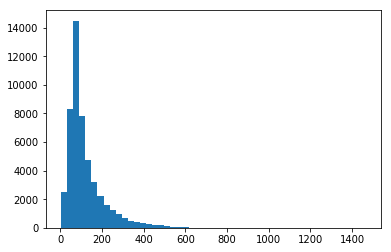

In [9]:
import matplotlib.pyplot as plt

plt.hist(lengths, bins = 50)

In [ ]:
max_length = 500

In [ ]:
def pad_data(tokens, max_length):
    res = []
    for word in tokens:
        idx = word2idx[word]
        res.append(idx)
    pad_idx = word2idx["<PAD>"]
    if len(res) < max_length:
        res.extend([pad_idx] * (max_length - len(res)))
    else:
        return np.array(res[:max_length])
    return np.array(res)

In [ ]:
train_data = [(pad_data(t, max_length), label) for t, label in train_data]
val_data = [(pad_data(t, max_length), label) for t, label in val_data]
test_data = [(pad_data(t, max_length), label) for t, label in test_data]

In [ ]:
x_train = np.array([t[0] for t in train_data])
y_train = np.array([t[1] for t in train_data])

x_val = np.array([t[0] for t in val_data])
y_val = np.array([t[1] for t in val_data])

x_test = np.array([t[0] for t in test_data])
y_test = np.array([t[1] for t in test_data])

In [ ]:
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Add, InputLayer, concatenate, SpatialDropout1D, Flatten

n_words = len(idx2word)
embedding_dim = 50
batch_size = 32

model = Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=embedding_dim, mask_zero=True),
    tf.keras.layers.Bidirectional(LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=10, verbose=1)